# Performance analysis

We investigate how well our `eval` query scales in a number of different
ways:

- In function of the number of hidden layers
- In function of the number of hidden nodes
- In function of the number of input vectors

We use DuckDB and the recursive variant of the query. Of course, our results
might look differently for other database systems or other versions of the
query, but at least this gives us a first impression.

## Preliminaries

All performance tests will use the same `eval` query, which we'll set up here.

In [1]:
import duckdb
import random
import time
import matplotlib.pyplot as plt
import numpy as np

eval_query = """
WITH RECURSIVE input_values AS (
    -- Fetch input values from an existing table
    SELECT input_set_id, input_node_idx, input_value FROM input
),
input_nodes AS (
    SELECT
        id,
        bias,
        ROW_NUMBER() OVER (ORDER BY id) AS input_node_idx
    FROM node
    WHERE id NOT IN
    (SELECT dst FROM edge)
),
output_nodes AS (
    SELECT id
    FROM node
    WHERE id NOT IN
    (SELECT src FROM edge)
),
tx AS (
    -- Base case (t1)
    SELECT
        v.input_set_id AS input_set_id,
        GREATEST(
            0,
            n.bias + SUM(e.weight * v.input_value)
        ) AS value,
        e.dst AS id
    FROM edge e
    JOIN input_nodes i ON i.id = e.src
    JOIN node n ON e.dst = n.id
    JOIN input_values v ON i.input_node_idx = v.input_node_idx
    GROUP BY e.dst, n.bias, v.input_set_id

    UNION ALL

    -- Recursive case
    SELECT
        tx.input_set_id AS input_set_id,
        GREATEST(
            0,
            n.bias + SUM(e.weight * tx.value)
        ) AS value,
        e.dst AS id
    FROM edge e
    JOIN tx ON tx.id = e.src
    JOIN node n ON e.dst = n.id
    GROUP BY e.dst, n.bias, tx.input_set_id
),
-- As the last step, repeat the calculation for the output nodes, but omit the
-- ReLU this time (per definition)
t_out AS (
    SELECT
        tx.input_set_id AS input_set_id,
        n.bias + SUM(e.weight * tx.value) AS value,
        e.dst AS id
    FROM edge e
    JOIN output_nodes o ON e.dst = o.id
    JOIN node n ON o.id = n.id
    JOIN tx ON tx.id = e.src
    GROUP BY e.dst, n.bias, tx.input_set_id
)
SELECT * FROM t_out ORDER BY id;
"""

We also need some code to set up the database. Note that we include a table that
holds all input values, as opposed to using hardcoded SELECTs as in previous
examples.

In [2]:
con = duckdb.connect()

def reset_db():
    con.sql("DROP TABLE IF EXISTS input")
    con.sql("DROP TABLE IF EXISTS edge")
    con.sql("DROP TABLE IF EXISTS node")
    con.sql("DROP SEQUENCE IF EXISTS seq_node")


    con.sql("CREATE SEQUENCE seq_node START 1")
    con.sql(
        """
        CREATE TABLE input(
            input_set_id INTEGER,
            input_node_idx INTEGER,
            input_value REAL
        )"""
    )
    con.sql(
        """
        CREATE TABLE node(
            id INTEGER PRIMARY KEY DEFAULT nextval('seq_node'),
            bias REAL
        )"""
    )
    con.sql(
        """
        CREATE TABLE edge(
            src INTEGER,
            dst INTEGER,
            weight REAL,
            FOREIGN KEY (src) REFERENCES node(id),
            FOREIGN KEY (dst) REFERENCES node(id)
        )"""
    )

reset_db()


Next up is a utility function that creates a network of the given dimensions,
with random weights and biases.

In [3]:
def create_network(num_input_nodes, num_nodes_per_layer, num_hidden_layers, num_output_nodes):
    # We create a big query string for performance reasons. It is faster than
    # inserting each node/edge separately.
    node_insert_query = "INSERT INTO node (bias) VALUES "

    # Insert input nodes.
    for _ in range(0, num_input_nodes):
        node_insert_query += "(0), "

    # Insert hidden nodes.
    for _ in range(0, num_hidden_layers * num_nodes_per_layer):
        # We don't use prepared statements to make things easier.
        bias = random.uniform(-10, 10)
        node_insert_query += f"({bias}), "

    # Insert output nodes.
    for _ in range(0, num_output_nodes):
        bias = random.uniform(-10, 10)
        node_insert_query += f"({bias}), "

    con.execute(node_insert_query)

    edge_insert_query = "INSERT INTO edge (src, dst, weight) VALUES "
    def insert_edge(from_node_id, to_node_id):
        weight = random.uniform(-10, 10)
        return f"({from_node_id}, {to_node_id}, {weight}), "

    # Insert edges from input nodes to first hidden layer
    for i_from in range(0, num_input_nodes):
        for i_to in range(num_input_nodes, num_input_nodes + num_nodes_per_layer):
            from_node_id = i_from + 1
            to_node_id = i_to + 1
            edge_insert_query += insert_edge(from_node_id, to_node_id)

    # Insert edges between hidden nodes
    for layer in range(0, num_hidden_layers - 1):
        for i_from in range(0, num_nodes_per_layer):
            for i_to in range(0, num_nodes_per_layer):
                from_node_id = num_input_nodes + (layer * num_nodes_per_layer) + i_from + 1
                to_node_id = num_input_nodes + ((layer + 1) * num_nodes_per_layer) + i_to + 1
                edge_insert_query += insert_edge(from_node_id, to_node_id)

    # And finally, insert edges from the last hidden layer to the output nodes
    for i_from in range(0, num_nodes_per_layer):
        for i_to in range(0, num_output_nodes):
            from_node_id = num_input_nodes + ((num_hidden_layers - 1) * num_nodes_per_layer) + i_from + 1
            to_node_id = num_input_nodes + (num_hidden_layers * num_nodes_per_layer) + i_to + 1
            edge_insert_query += insert_edge(from_node_id, to_node_id)

    con.execute(edge_insert_query)

And finally a utility function that creates random input values.

In [16]:
def create_random_input(num_input_nodes, num_input_sets):
    con.execute("TRUNCATE TABLE input")

    for input_set_id in range(0, num_input_sets):
        for input_node_idx in range(0, num_input_nodes):
            con.execute("""
                INSERT INTO input(input_set_id, input_node_idx, input_value)
                VALUES ($input_set_id, $input_node_idx, $input_value)""",
                {
                    'input_set_id': input_set_id,
                    'input_node_idx': input_node_idx,
                    'input_value': random.uniform(-10, 10)
                })

## Scaling the number of hidden layers

This is similar to [our DuckDB performance
analysis](./4.1%20Aside%20-%20DuckDB%20bugreport.ipynb), except that we do a
proper `eval` query here. We create a neural network with random weights and
biases, increasing the number of layers in each iteration.

In [5]:
def measure_performance(num_hidden_layers):
    reset_db()
    create_network(
        num_input_nodes=2,
        num_nodes_per_layer=3,
        num_hidden_layers=num_hidden_layers,
        num_output_nodes=2
    )
    create_random_input(2, 1)

    start = time.time()
    output = con.sql(eval_query).fetchall()
    end = time.time()

    print(f"Querying {num_hidden_layers} hidden layers took {end - start}s")

    return end - start

timings = [measure_performance(num_layers * 100) for num_layers in range(2, 21)]

Querying 200 hidden layers took 0.25023961067199707s
Querying 300 hidden layers took 0.42375898361206055s
Querying 400 hidden layers took 0.6577143669128418s
Querying 500 hidden layers took 0.9675965309143066s
Querying 600 hidden layers took 1.2369468212127686s
Querying 700 hidden layers took 0.6073980331420898s
Querying 800 hidden layers took 0.6617538928985596s
Querying 900 hidden layers took 0.7904722690582275s
Querying 1000 hidden layers took 0.8498647212982178s
Querying 1100 hidden layers took 0.9017219543457031s
Querying 1200 hidden layers took 1.0447208881378174s
Querying 1300 hidden layers took 1.1432502269744873s
Querying 1400 hidden layers took 1.2522094249725342s
Querying 1500 hidden layers took 1.297398328781128s
Querying 1600 hidden layers took 1.4244060516357422s
Querying 1700 hidden layers took 1.5674374103546143s
Querying 1800 hidden layers took 1.6519310474395752s
Querying 1900 hidden layers took 1.8058407306671143s
Querying 2000 hidden layers took 1.8247528076171875s


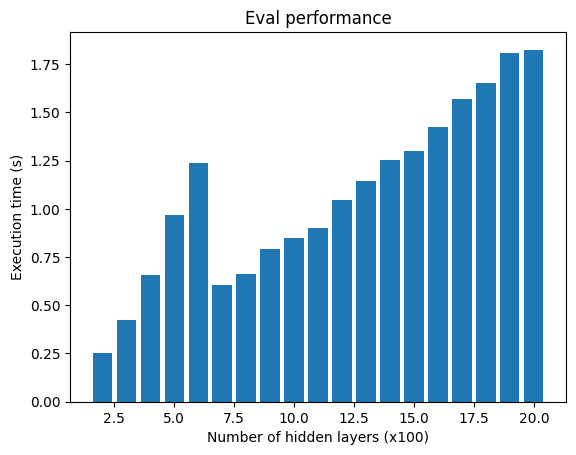

In [6]:
plt.bar(range(2, 21), timings)
plt.xlabel('Number of hidden layers (x100)')
plt.ylabel('Execution time (s)')
plt.title('Eval performance')
plt.show()

We can see linear scaling for the number of hidden layers, with a reset at ~6000
layers.

## Scaling the number of hidden nodes

Now instead of increasing the number of hidden layers, we'll use a fixed amount
(10) and scale up the number of hidden nodes in each layer.

In [7]:
database_timings = []

def measure_performance(num_nodes_per_layer):
    start = time.time()
    reset_db()
    create_network(
        num_input_nodes=2,
        num_nodes_per_layer=num_nodes_per_layer,
        num_hidden_layers=10,
        num_output_nodes=2
    )
    create_random_input(2, 1)
    end = time.time()
    database_timings.append(end - start)

    start = time.time()
    output = con.sql(eval_query).fetchall()
    end = time.time()

    print(f"Querying {num_nodes_per_layer} nodes per layer took {end - start}s")

    return end - start

timings = [measure_performance(num_nodes_per_layer * 10) for num_nodes_per_layer in range(2, 21)]

Querying 20 nodes per layer took 0.02027583122253418s
Querying 30 nodes per layer took 0.01937556266784668s
Querying 40 nodes per layer took 0.028153181076049805s
Querying 50 nodes per layer took 0.02360820770263672s
Querying 60 nodes per layer took 0.027592182159423828s
Querying 70 nodes per layer took 0.030208110809326172s
Querying 80 nodes per layer took 0.0319516658782959s
Querying 90 nodes per layer took 0.03496909141540527s
Querying 100 nodes per layer took 0.03484988212585449s
Querying 110 nodes per layer took 0.04220390319824219s
Querying 120 nodes per layer took 0.04451417922973633s
Querying 130 nodes per layer took 0.05370330810546875s
Querying 140 nodes per layer took 0.06109118461608887s
Querying 150 nodes per layer took 0.05448150634765625s
Querying 160 nodes per layer took 0.0637364387512207s
Querying 170 nodes per layer took 0.06404590606689453s
Querying 180 nodes per layer took 0.07805848121643066s
Querying 190 nodes per layer took 0.0802621841430664s
Querying 200 nodes

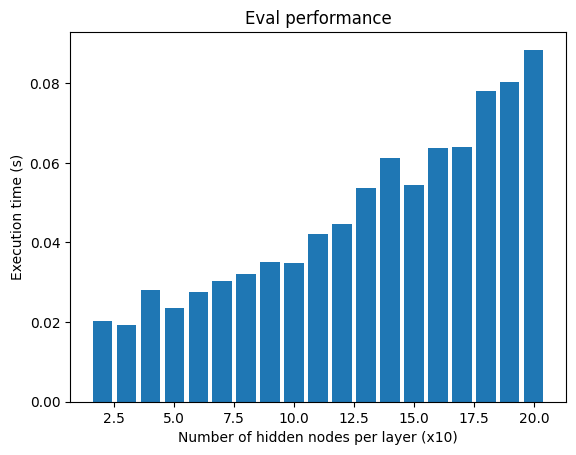

In [8]:
plt.bar(range(2, 21), timings)
plt.xlabel('Number of hidden nodes per layer (x10)')
plt.ylabel('Execution time (s)')
plt.title('Eval performance')
plt.show()

For this somewhat low number of hidden nodes per layer (we end at 200), we can
see linear scaling as well. Note that the execution time is actually on the low
side. We don't test more hidden nodes per layer because the database creation
actually slows down a lot, since the number of edges increases quadratically.
For example, creating the database with 200 hidden nodes per layer took about 7
seconds, whereas querying took only 70ms.

This graph shows the database creation times and the actual query times next to
eachother, to illustrate the problem.

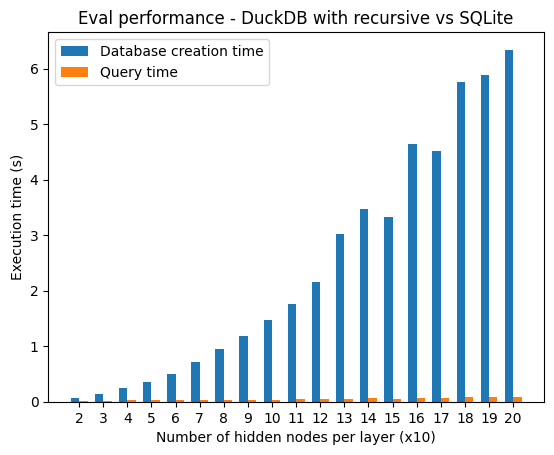

In [14]:
xs = range(2, 21)
y1 = database_timings
y2 = timings

bar_width = 0.35
index = np.arange(len(xs))

plt.bar(index, y1, bar_width, label='Database creation time')
plt.bar(index + bar_width, y2, bar_width, label='Query time')

plt.xlabel('Number of hidden nodes per layer (x10)')
plt.ylabel('Execution time (s)')
plt.title('Eval performance - DuckDB with recursive vs SQLite')

plt.xticks(index + bar_width / 2, xs)
plt.legend()
plt.show()

## Scaling the number of input vectors

Let's also look at how our query performs when we increase the number of input
vectors that we evaluate in one go. We'll take a reasonably sized neural network
with 5 hidden layers, 200 hidden nodes per layer, 784 input nodes, and 10 output
nodes. The input and output nodes correspond to the MNIST dataset, which has
28x28 images of 10 different classes (the digits).

In [19]:
# Our network is static, so we only need to create it once.
reset_db()
create_network(
    num_input_nodes=784,
    num_nodes_per_layer=200,
    num_hidden_layers=5,
    num_output_nodes=10
)

In [25]:
def measure_performance(num_input_sets):
    create_random_input(2, num_input_sets)

    start = time.time()
    output = con.sql(eval_query).fetchall()
    end = time.time()

    print(f"Querying {num_input_sets} input images took {end - start}s")

    return end - start

timings = [measure_performance(num_input_sets * 10) for num_input_sets in range(1, 21)]

Querying 10 input images took 0.2406759262084961s
Querying 20 input images took 0.20116519927978516s
Querying 30 input images took 0.338451623916626s
Querying 40 input images took 0.33101725578308105s
Querying 50 input images took 0.442995548248291s
Querying 60 input images took 0.46463847160339355s
Querying 70 input images took 0.5857663154602051s
Querying 80 input images took 0.6645333766937256s
Querying 90 input images took 0.6861891746520996s
Querying 100 input images took 0.7174351215362549s
Querying 110 input images took 0.7651541233062744s
Querying 120 input images took 0.8973183631896973s
Querying 130 input images took 0.9546718597412109s
Querying 140 input images took 0.9781343936920166s
Querying 150 input images took 1.0343692302703857s
Querying 160 input images took 1.1526069641113281s
Querying 170 input images took 1.1989617347717285s
Querying 180 input images took 1.2537894248962402s
Querying 190 input images took 1.3054699897766113s
Querying 200 input images took 1.349438

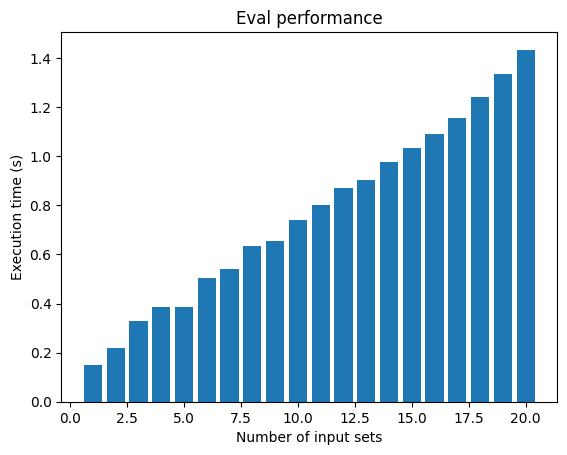

In [23]:
plt.bar(range(1, 21), timings)
plt.xlabel('Number of input sets (x10)')
plt.ylabel('Execution time (s)')
plt.title('Eval performance')
plt.show()

We can see linear scaling again. Note that the largest amount if input images we
tried is 200. This corresponds to 156,800 individual input values, which the
query calculates in a little over 1.4 seconds.